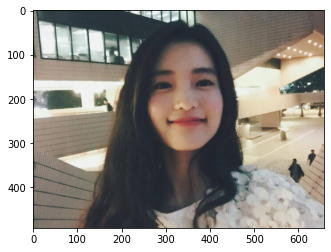

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

my_image_path =os.getenv('HOME') + '/aiffel/camera_sticker/images/selfie_1.jpg'
img_bgr = cv2.imread(my_image_path) #opencv >> bgr
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb) #matplotlib >> rgb
plt.show()

rectangles[[(242, 118) (428, 304)]]


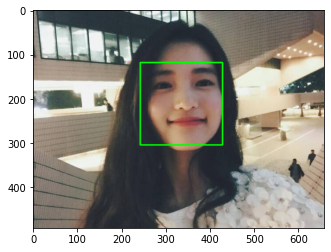

In [2]:
#HOG dectector
face_detector = dlib.get_frontal_face_detector()
dlib_rects = face_detector(img_rgb, 1) #dib >> rgb 
print(dlib_rects) # dlib dectector >> type: rectangles

#showing rectangles
img_show = img_bgr.copy()

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

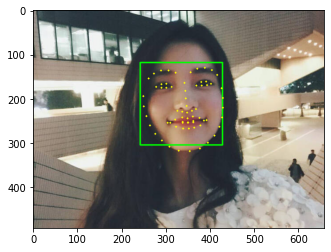

In [3]:
#object keypoint estimation
#top-down approach: object detection > keypoint estimation

#estimation model : Dlib AFLW(68 face landmark points)
model_path = os.getenv('HOME') + '/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

[  0   0   0 255]
[255 255 255   0]


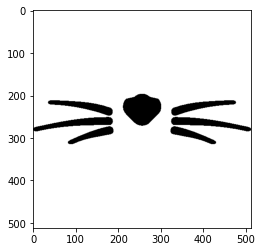

In [4]:
#sticker load
img_bgra = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2BGRA)
img_show = img_bgra

sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker_bgr = cv2.imread(sticker_path)
img_sticker_rgb = cv2.cvtColor(img_sticker_bgr, cv2.COLOR_BGR2RGB)

#bgra img read
img_sticker_bgra = cv2.imread(sticker_path, cv2.IMREAD_UNCHANGED)
img_sticker = img_sticker_bgra
print(img_sticker[250,250])
print(img_sticker[0,250])

plt.imshow(img_sticker_rgb)
plt.show()

nose(x,y) : (347,216)
dlib_rect(w,h) : (187,187)
sticker_size(w,h) : (150,150)
sticker_crop(x,y) : (272,141)


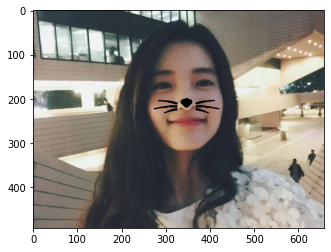

In [5]:
#sticker location : nose
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
#     print (landmark[30]) # nose index : 30
    x = landmark[30][0]
    y = landmark[30][1]
    w = h = dlib_rect.width()
    w_sticker = w-w//5
    h_sticker = h-h//5
    img_sticker = cv2.resize(img_sticker, (w_sticker,h_sticker))
    print (f'nose(x,y) : ({x},{y})')
    print (f'dlib_rect(w,h) : ({w},{h})')
    print (f'sticker_size(w,h) : ({len(img_sticker[0])},{len(img_sticker[1])})')

    refined_x = x - w_sticker//2
    refined_y = y - h_sticker//2

    #crop
    if refined_x < 0: 
        img_sticker = img_sticker[:, -refined_x:]
        refined_x = 0

    if refined_y < 0:
        img_sticker = img_sticker[-refined_y:, :]
        refined_y = 0
    print (f'sticker_crop(x,y) : ({refined_x},{refined_y})')
    
    sticker_area = img_bgra[refined_y:refined_y+img_sticker.shape[0] \
                            , refined_x:refined_x+img_sticker.shape[1], :3]  # Remove the alpha channel
    sticker_alpha = img_sticker[:, :, 3]  # alpha channel
    sticker_rgb = img_sticker[:, :, :3]  # rgb channel

    # Apply the sticker if alpha > 0
    sticker_applied = np.where(sticker_alpha[..., None] > 0, sticker_rgb, sticker_area)

    img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1], :3] = sticker_applied.astype(np.uint8)

    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGRA2RGBA))
    plt.show()

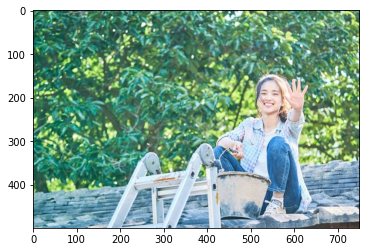

In [6]:
########################
#new image

my_image_path =os.getenv('HOME') + '/aiffel/camera_sticker/images'

selfie_path = my_image_path+'/selfie_2.jpg'
img_bgra = cv2.imread(selfie_path, cv2.IMREAD_UNCHANGED) 
img_rgba = cv2.cvtColor(img_bgra, cv2.COLOR_BGRA2RGBA)

plt.imshow(img_rgba)
plt.show()

In [7]:
#define function's above
def get_rects_landmarks(_img, _face_detector, _landmark_predictor,):
    img_show = _img.copy()
    img_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGRA2RGB)
    dlib_rects = _face_detector(img_rgb, 1)
    
    list_landmarks = []
    for dlib_rect in dlib_rects:
        points = _landmark_predictor(img_rgb, dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
        l = dlib_rect.left()
        t = dlib_rect.top()
        r = dlib_rect.right()
        b = dlib_rect.bottom()

        cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
        for point in landmark:
            cv2.circle(img_show, point, 2, (0, 255, 255), -1)
        
    return dlib_rects, list_landmarks, img_show

def add_sticker(_img, _dlib_rects, _list_landmarks, _img_sticker):
    img_show = _img.copy()
   
    for dlib_rect, landmark in zip(_dlib_rects, _list_landmarks):
        x = landmark[30][0]
        y = landmark[30][1]
        w = h = dlib_rect.width()
        w_sticker = w-w//5
        h_sticker = h-h//5
        img_sticker = cv2.resize(_img_sticker, (w_sticker,h_sticker))
        refined_x = x - w_sticker//2
        refined_y = y - h_sticker//2

        #crop
        if refined_x < 0: 
            img_sticker = img_sticker[:, -refined_x:]
            refined_x = 0

        if refined_y < 0:
            img_sticker = img_sticker[-refined_y:, :]
            refined_y = 0
    
        sticker_area = img_bgra[refined_y:refined_y+img_sticker.shape[0] \
                                , refined_x:refined_x+img_sticker.shape[1], :3]  # Remove the alpha channel
        sticker_alpha = img_sticker[:, :, 3]  # alpha channel
        sticker_rgb = img_sticker[:, :, :3]  # rgb channel

        sticker_applied = np.where(sticker_alpha[..., None] > 0, sticker_rgb, sticker_area)  # Apply the sticker

        img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1], :3] \
        = sticker_applied.astype(np.uint8)
    return img_show

In [8]:
face_detector = dlib.get_frontal_face_detector()
model_path = os.getenv('HOME') + '/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

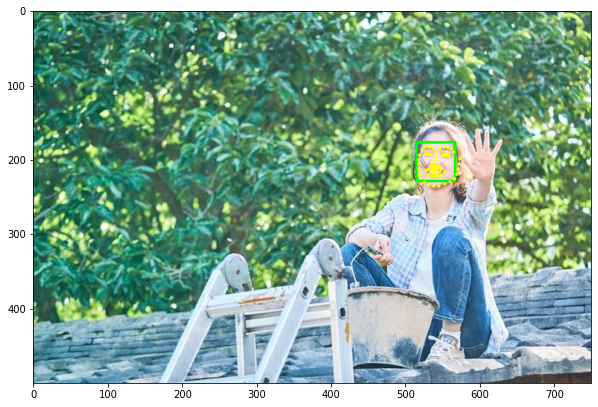

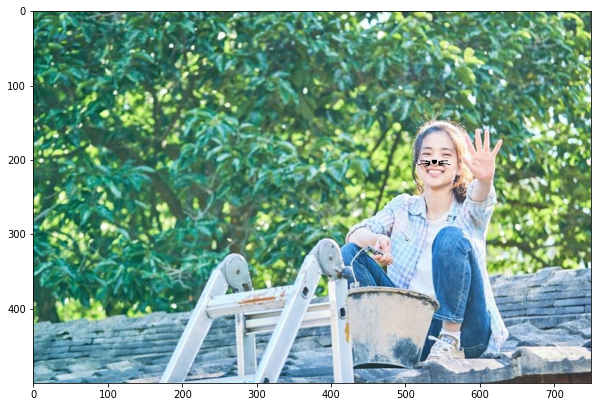

In [9]:
#img test_small face

selfie_path = my_image_path+'/selfie_2.jpg'
img_bgra = cv2.imread(selfie_path, cv2.IMREAD_UNCHANGED) 
img_rgba = cv2.cvtColor(img_bgra, cv2.COLOR_BGRA2RGBA)

sticker_path = my_image_path+ '/cat-whiskers.png'
img_sticker_bgra = cv2.imread(sticker_path, cv2.IMREAD_UNCHANGED)
img_sticker = img_sticker_bgra

plt.figure(figsize=(10,10))
dlib_rects, list_landmarks, img_rects_landmarks = get_rects_landmarks(img_bgra, face_detector, landmark_predictor)
plt.imshow(cv2.cvtColor(img_rects_landmarks, cv2.COLOR_BGRA2RGBA))
plt.show()

plt.figure(figsize=(10,10))
img_add_sticker = add_sticker(img_bgra, dlib_rects, list_landmarks, img_sticker)
plt.imshow(cv2.cvtColor(img_add_sticker, cv2.COLOR_BGRA2RGBA))
plt.show()

In [ ]:
"""
#resizing이 잘 작동하는 것 같다

w = h = dlib_rect.width()
        w_sticker = w-w//5
        h_sticker = h-h//5
        img_sticker = cv2.resize(_img_sticker, (w_sticker,h_sticker))
        refined_x = x - w_sticker//2
        refined_y = y - h_sticker//2
        
"""

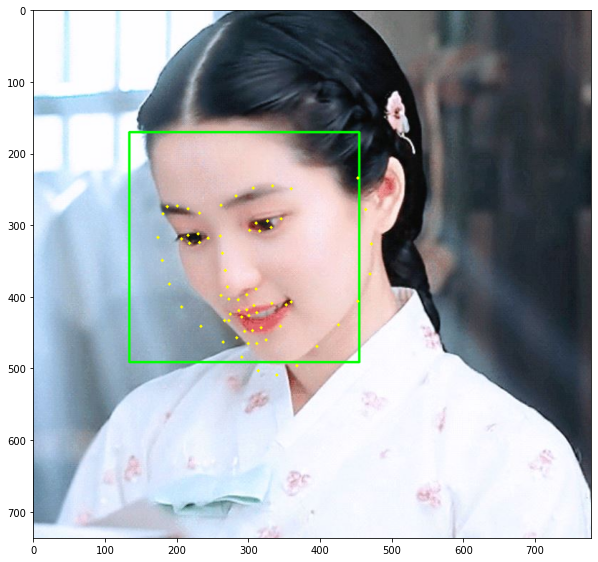

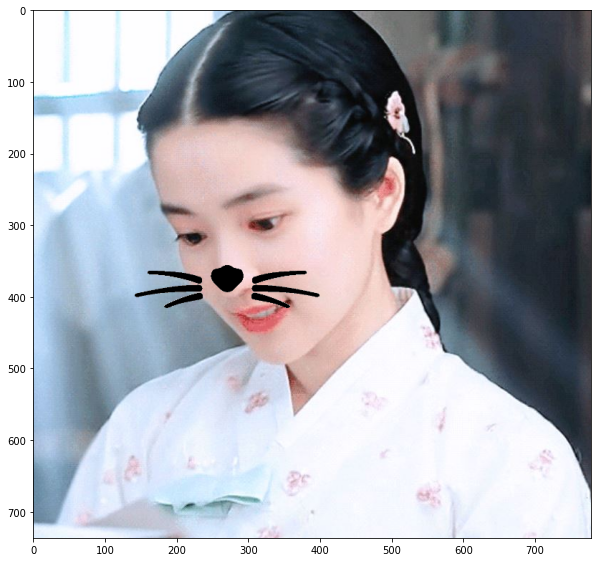

In [10]:
#test img : rotated face - selfie_3,4
selfie_path = my_image_path +'/selfie_3.jpg'
img_bgra = cv2.imread(selfie_path, cv2.IMREAD_UNCHANGED) 
img_rgba = cv2.cvtColor(img_bgra, cv2.COLOR_BGRA2RGBA)

plt.figure(figsize=(10,10))
dlib_rects, list_landmarks, img_rects_landmarks = get_rects_landmarks(img_bgra, face_detector, landmark_predictor)
plt.imshow(cv2.cvtColor(img_rects_landmarks, cv2.COLOR_BGRA2RGBA))
plt.show()

plt.figure(figsize=(10,10))
img_add_sticker = add_sticker(img_bgra, dlib_rects, list_landmarks, img_sticker)
plt.imshow(cv2.cvtColor(img_add_sticker, cv2.COLOR_BGRA2RGBA))
plt.show()

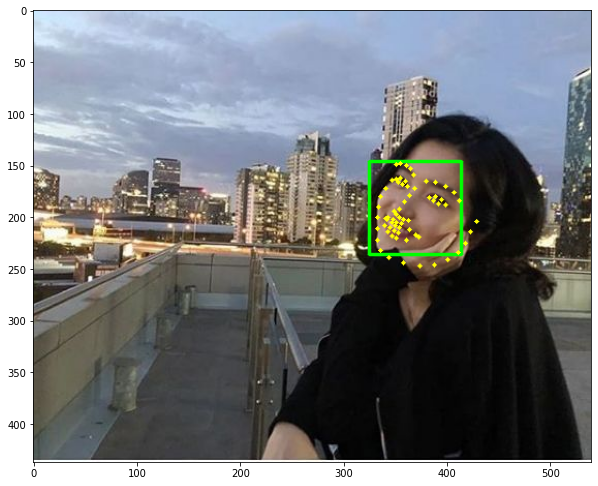

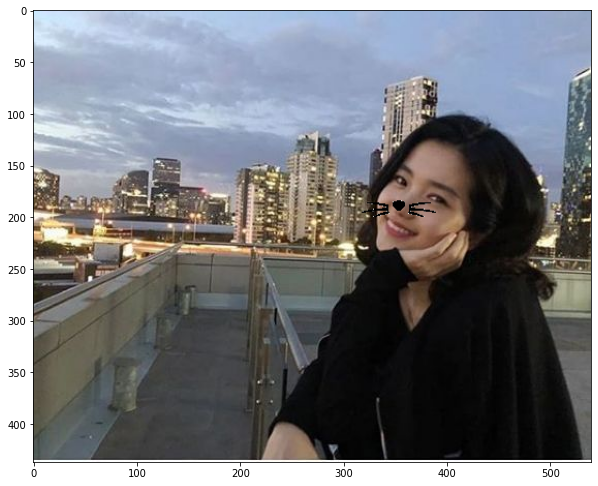

In [11]:
selfie_path = my_image_path+'/selfie_4.jpg'
img_bgra = cv2.imread(selfie_path, cv2.IMREAD_UNCHANGED) 
img_rgba = cv2.cvtColor(img_bgra, cv2.COLOR_BGRA2RGBA)

plt.figure(figsize=(10,10))
dlib_rects, list_landmarks, img_rects_landmarks = get_rects_landmarks(img_bgra, face_detector, landmark_predictor)
plt.imshow(cv2.cvtColor(img_rects_landmarks, cv2.COLOR_BGRA2RGBA))
plt.show()

plt.figure(figsize=(10,10))
img_add_sticker = add_sticker(img_bgra, dlib_rects, list_landmarks, img_sticker)
plt.imshow(cv2.cvtColor(img_add_sticker, cv2.COLOR_BGRA2RGBA))
plt.show()

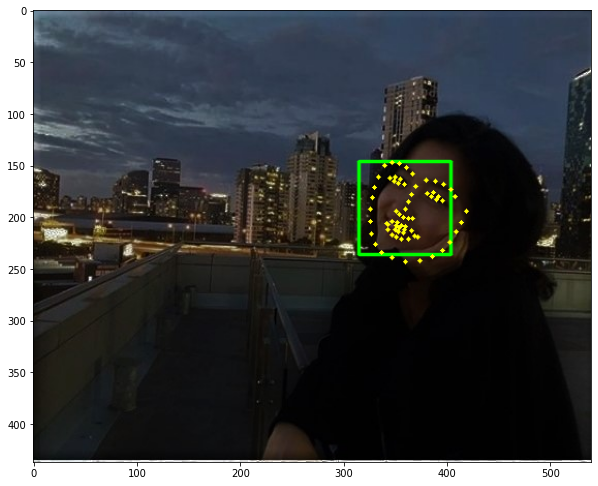

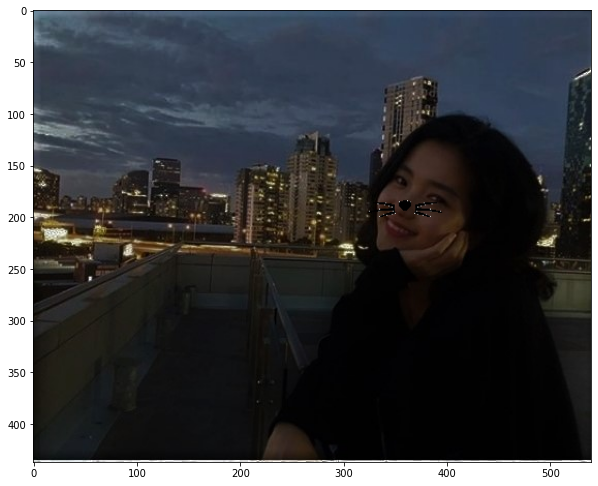

In [19]:
#test img : brightness - selfie_4_2
selfie_path = my_image_path +'/selfie_4_2.jpg'
img_bgra = cv2.imread(selfie_path, cv2.IMREAD_UNCHANGED) 
img_rgba = cv2.cvtColor(img_bgra, cv2.COLOR_BGRA2RGBA)

plt.figure(figsize=(10,10))
dlib_rects, list_landmarks, img_rects_landmarks = get_rects_landmarks(img_bgra, face_detector, landmark_predictor)
plt.imshow(cv2.cvtColor(img_rects_landmarks, cv2.COLOR_BGRA2RGBA))
plt.show()

plt.figure(figsize=(10,10))
img_add_sticker = add_sticker(img_bgra, dlib_rects, list_landmarks, img_sticker)
plt.imshow(cv2.cvtColor(img_add_sticker, cv2.COLOR_BGRA2RGBA))
plt.show()

In [ ]:
'''
밝기 조절시에는 큰 변화가 없으나, 얼굴 각도 변화에 따를 스티커 각도의 조절이 필요해보임

'''

In [12]:
import math

def get_angle(landmark):
    dy = landmark[57][1] - landmark[27][1]
    dx = landmark[57][0] - landmark[27][0]
    return ((math.atan2(dx, dy) * (180.0 / math.pi)))

def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR,borderValue=(255,255,255))
    return result

In [13]:
def add_sticker_rotate(_img, _dlib_rects, _list_landmarks, _img_sticker):
    img_show = _img.copy()
  
    for dlib_rect, landmark in zip(_dlib_rects, _list_landmarks):

        x = landmark[30][0]
        y = landmark[30][1] 
  
        w = dlib_rect.width()
        h = dlib_rect.height()
        w_sticker = w-w//5
        h_sticker = h-h//5
        
        angle = get_angle(landmark)
        print(angle)
        img_sticker_rotate = rotate_image(_img_sticker, angle)
        img_sticker_rotate = cv2.resize(img_sticker_rotate, (w_sticker,h_sticker))
        
        refined_x = x - w_sticker// 2              
        refined_y = y - h_sticker// 2
        
        if refined_x < 0: 
            img_sticker_rotate = img_sticker_rotate[:, -refined_x:]
            refined_x = 0
        if refined_y < 0:
            img_sticker_rotate = img_sticker_rotate[-refined_y:, :] 
            refined_y = 0
        
        sticker_area = img_bgra[refined_y:refined_y+img_sticker_rotate.shape[0] \
                                , refined_x:refined_x+img_sticker_rotate.shape[1], :3]  # Remove the alpha channel
        sticker_alpha = img_sticker_rotate[:, :, 3]  # alpha channel
        sticker_rgb = img_sticker_rotate[:, :, :3]  # rgb channel

        sticker_applied = np.where(sticker_alpha[..., None] > 64, sticker_rgb, sticker_area)  # Apply the sticker

        img_show[refined_y:refined_y+img_sticker_rotate.shape[0], refined_x:refined_x+img_sticker_rotate.shape[1], :3] \
        = sticker_applied.astype(np.uint8)
        
    return img_show

18.77803322244554


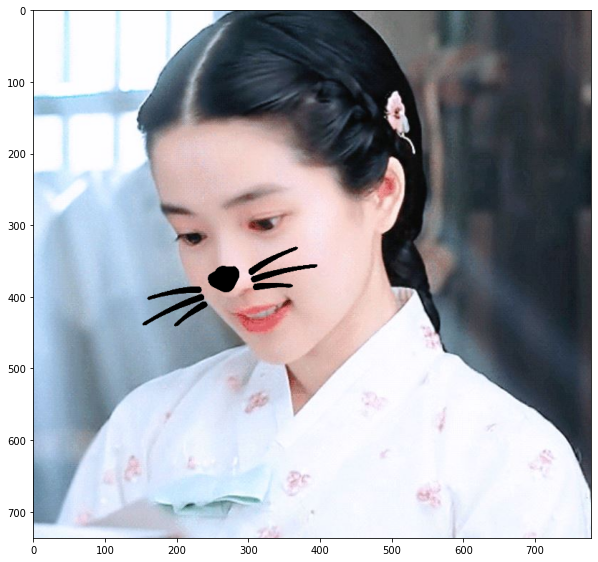

In [14]:
selfie_path = my_image_path+'/selfie_3.jpg'
img_bgra = cv2.imread(selfie_path, cv2.IMREAD_UNCHANGED) 
img_rgba = cv2.cvtColor(img_bgra, cv2.COLOR_BGRA2RGBA)

dlib_rects, list_landmarks, img_rects_landmarks = get_rects_landmarks(img_bgra, face_detector, landmark_predictor)
scicker_add_sticker_rotate = add_sticker_rotate(img_bgra, dlib_rects, list_landmarks, img_sticker)

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(scicker_add_sticker_rotate, cv2.COLOR_BGRA2RGBA))
plt.show()


-25.559965171823812


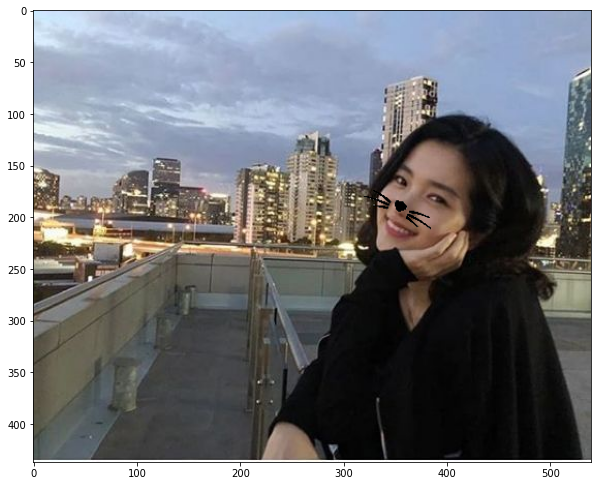

In [15]:
selfie_path = my_image_path+'/selfie_4.jpg'
img_bgra = cv2.imread(selfie_path, cv2.IMREAD_UNCHANGED) 
img_rgba = cv2.cvtColor(img_bgra, cv2.COLOR_BGRA2RGBA)

dlib_rects, list_landmarks, img_rects_landmarks = get_rects_landmarks(img_bgra, face_detector, landmark_predictor)
scicker_add_sticker_rotate = add_sticker_rotate(img_bgra, dlib_rects, list_landmarks, img_sticker)

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(scicker_add_sticker_rotate, cv2.COLOR_BGRA2RGBA))
plt.show()

-21.501434324047903
27.216111557307478
-27.979474388480146


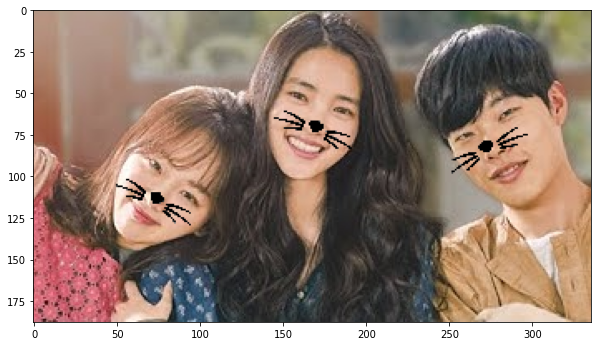

In [16]:
selfie_path = my_image_path+'/selfie_5.jpg'
img_bgra = cv2.imread(selfie_path, cv2.IMREAD_UNCHANGED) 
img_rgba = cv2.cvtColor(img_bgra, cv2.COLOR_BGRA2RGBA)

dlib_rects, list_landmarks, img_rects_landmarks = get_rects_landmarks(img_bgra, face_detector, landmark_predictor)
scicker_add_sticker_rotate = add_sticker_rotate(img_bgra, dlib_rects, list_landmarks, img_sticker)

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(scicker_add_sticker_rotate, cv2.COLOR_BGRA2RGBA))
plt.show()